In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
# from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aashan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aashan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Aashan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# load the dataset
data_path="9.Spam vs Ham Sms Dataset/spamvsham.csv"
df = pd.read_csv(data_path, encoding='latin1')

In [3]:
# print the first five rows of the dataset
print(df.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [4]:
# Check the sum of null values in each column of the DataFrame
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [5]:
df.count()

v1            5572
v2            5572
Unnamed: 2      50
Unnamed: 3      12
Unnamed: 4       6
dtype: int64

In [6]:
# basic cleaning tasks
df = df[['v2', 'v1']] # selecting only 'review' and 'rating' columns
df = df.dropna() # remove rows with missing values

**Text Preprocessing, Tokenization, and Sequence Padding:**

In [7]:
!pip install contractions

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # Remove mentions/hashtags
    text = re.sub(r"[^a-z\s]", '', text)  # Remove numbers & special characters
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_v2'] = df['v2'].apply(clean_text)


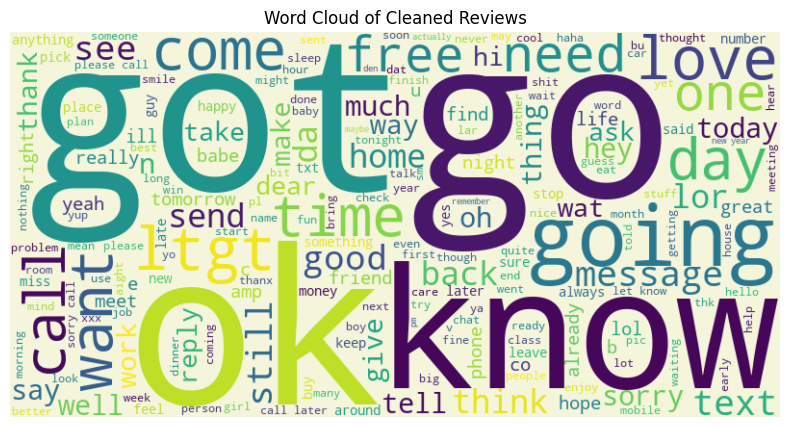

[('call', 603), ('get', 401), ('go', 308), ('know', 302), ('free', 278), ('ok', 277), ('ltgt', 276), ('day', 255), ('got', 251), ('want', 251), ('come', 247), ('like', 245), ('love', 237), ('going', 236), ('good', 235), ('time', 233), ('text', 215), ('send', 190), ('message', 186), ('need', 182)]


In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Word Cloud
text = ' '.join(df['cleaned_v2'])
wordcloud = WordCloud(width=800, height=400, background_color='beige').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Reviews")
plt.show()

# Most common words
word_freq = Counter(" ".join(df['cleaned_v2']).split())
print(word_freq.most_common(20))


In [10]:
# Step 1: Clean it and rename
df = df[['v1', 'v2']].copy()
df.columns = ['label', 'text']

# Map labels to binary values: 'ham' = 0, 'spam' = 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Optional: Clean the message text (e.g., lowercase and remove punctuation)
df['cleaned_v2'] = df['text'].str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True)

# Step 2: Define features and labels
X = df['cleaned_v2']
y = df['label']

# Step 3: Split into 80% training and 20% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Step 4: Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Step 5: Padding
sequence_lengths = [len(seq) for seq in train_sequences]
max_length = int(np.percentile(sequence_lengths, 95))

padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Step 6: Print information
print(f"Found {len(tokenizer.word_index)} unique tokens.")
print(f"Maximum sequence length (95th percentile): {max_length}")
print(f"Shape of padded training sequences: {padded_train_sequences.shape}")
print(f"Shape of padded test sequences: {padded_test_sequences.shape}")


Training set size: 4457
Testing set size: 1115
Found 8377 unique tokens.
Maximum sequence length (95th percentile): 32
Shape of padded training sequences: (4457, 32)
Shape of padded test sequences: (1115, 32)


**Model Building and Training:**

In [11]:
# Import libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Confirm if it's binary classification
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# Binary classification setup
y_train_cat = y_train
y_test_cat = y_test
output_units = 1
activation = 'sigmoid'
loss = 'binary_crossentropy'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model_rnn.h5', monitor='val_accuracy', save_best_only=True)
]

# Embedding and vocabulary setup
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

# Build the Simple RNN model
print("Building Model: Simple RNN for binary classification")
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(output_units, activation=activation)
])

# Compile the model
model1.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

# Model structure
model1.build((None, max_length))
model1.summary()

# Train the model
history1 = model1.fit(
    padded_train_sequences, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

# Evaluate the model
print("\nEvaluating on test set...")
y_pred_probs = model1.predict(padded_test_sequences)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_cat, y_pred, target_names=["Ham", "Spam"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test_cat, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test_cat, y_pred))


Number of classes: 2
Building Model: Simple RNN for binary classification


C:\Users\Aashan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 100)             │         837,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          29,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 875,433 (3.34 MB)

 Trainable params: 875,433 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7131 - loss: 0.5467

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7180 - loss: 0.5428 - val_accuracy: 0.8565 - val_loss: 0.4064
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8643 - loss: 0.3996 - val_accuracy: 0.8565 - val_loss: 0.3947
Epoch 3/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8953 - loss: 0.3091

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8960 - loss: 0.3071 - val_accuracy: 0.9596 - val_loss: 0.0994
Epoch 4/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9834 - loss: 0.0701

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9834 - loss: 0.0699 - val_accuracy: 0.9664 - val_loss: 0.1409
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9897 - loss: 0.0349 - val_accuracy: 0.9664 - val_loss: 0.1451
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9916 - loss: 0.0237

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9916 - loss: 0.0236 - val_accuracy: 0.9709 - val_loss: 0.1533

Evaluating on test set...
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       965
        Spam       0.95      0.88      0.91       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[958   7]
 [ 18 132]]
Accuracy Score:
0.9775784753363229


In [12]:
# Binary classification setup
output_units = 1
activation = 'sigmoid'
loss = 'binary_crossentropy'

# Reuse from previous tokenizer setup
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # You can adjust as needed

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model_lstm.h5', monitor='val_accuracy', save_best_only=True)
]

# Build Model 2: LSTM
print("Building Model 2: LSTM with trainable Embedding")
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(output_units, activation=activation)
])

# Compile the model
model2.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

# Show model summary
model2.build((None, max_length))
model2.summary()

# Train Model 2
history2 = model2.fit(
    padded_train_sequences, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

# Evaluate Model 2
print("\nEvaluating on test set...")
y_pred_probs = model2.predict(padded_test_sequences)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Building Model 2: LSTM with trainable Embedding


C:\Users\Aashan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 32, 100)             │         837,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 963,369 (3.67 MB)

 Trainable params: 963,369 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8526 - loss: 0.4190

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.8534 - loss: 0.4168 - val_accuracy: 0.9552 - val_loss: 0.1688
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9841 - loss: 0.0645

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9841 - loss: 0.0643 - val_accuracy: 0.9731 - val_loss: 0.0768
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9937 - loss: 0.0236

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9937 - loss: 0.0236 - val_accuracy: 0.9753 - val_loss: 0.0780
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.9979 - loss: 0.0108 - val_accuracy: 0.9731 - val_loss: 0.1220
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9976 - loss: 0.0071 - val_accuracy: 0.9709 - val_loss: 0.1028

Evaluating on test set...
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       965
        Spam       0.99      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[963   2]
 [ 17 133]]
Accuracy Score:
0.9829596412556054


In [13]:
# Install gensim if not already installed
!pip install gensim

# Step 1: Import required libraries
import numpy as np
import gensim.downloader as api
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 2: Load pretrained GloVe embeddings
print("Loading pretrained GloVe embeddings...")
embedding_model = api.load('glove-wiki-gigaword-50')  # 50-dimensional
embedding_dim = 50

# Step 3: Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

# Step 4: Define model parameters for binary classification
output_units = 1
activation = 'sigmoid'
loss = 'binary_crossentropy'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model_glove.h5', monitor='val_accuracy', save_best_only=True)
]

# Step 5: Build the LSTM model with non-trainable GloVe embeddings
print("Building Model 3: LSTM with pretrained GloVe embeddings")
model3 = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False  # freeze GloVe embeddings
    ),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(output_units, activation=activation)
])

# Step 6: Compile the model
model3.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

# Show model structure
model3.build((None, max_length))
model3.summary()

# Step 7: Train the model
history3 = model3.fit(
    padded_train_sequences,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

# Step 8: Evaluate the model
print("\nEvaluating on test set...")
y_pred_probs = model3.predict(padded_test_sequences)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


Loading pretrained GloVe embeddings...
Building Model 3: LSTM with pretrained GloVe embeddings


C:\Users\Aashan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 32, 50)              │         418,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 518,869 (1.98 MB)

 Trainable params: 99,969 (390.50 KB)

 Non-trainable params: 418,900 (1.60 MB)

Epoch 1/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8389 - loss: 0.3907

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8409 - loss: 0.3867 - val_accuracy: 0.9395 - val_loss: 0.1717
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9528 - loss: 0.1376

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9529 - loss: 0.1374 - val_accuracy: 0.9484 - val_loss: 0.1754
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9567 - loss: 0.1194

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9567 - loss: 0.1194 - val_accuracy: 0.9596 - val_loss: 0.1319
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9666 - loss: 0.1049 - val_accuracy: 0.9484 - val_loss: 0.1283
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9726 - loss: 0.0810 - val_accuracy: 0.9462 - val_loss: 0.1313
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9729 - loss: 0.0824 - val_accuracy: 0.9552 - val_loss: 0.1188
Epoch 7/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9743 - loss: 0.0790

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9743 - loss: 0.0788 - val_accuracy: 0.9641 - val_loss: 0.1282
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9734 - loss: 0.0761 - val_accuracy: 0.9574 - val_loss: 0.1201
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9746 - loss: 0.0724 - val_accuracy: 0.9596 - val_loss: 0.1228

Evaluating on test set...
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      0.99      0.98       965
        Spam       0.95      0.82      0.88       150

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
[[958   7]
 [ 27 123]]
Accuracy Score:
0.9695067264573991


In [14]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


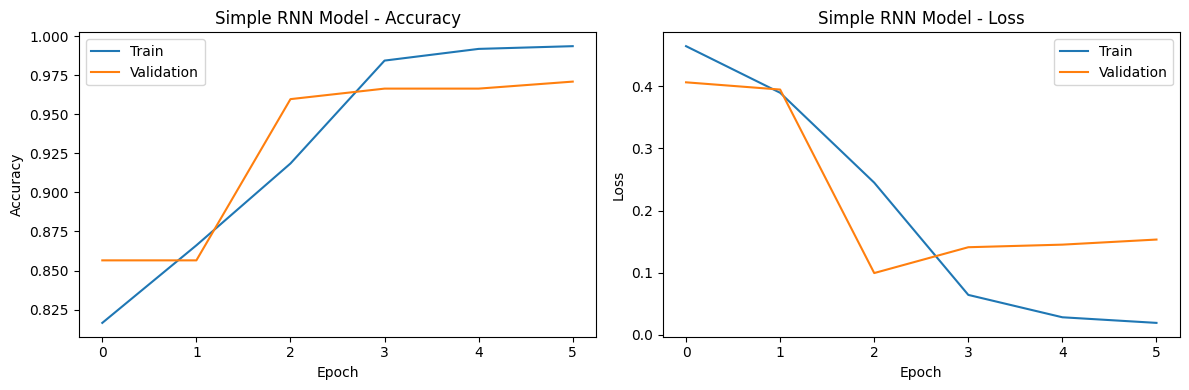

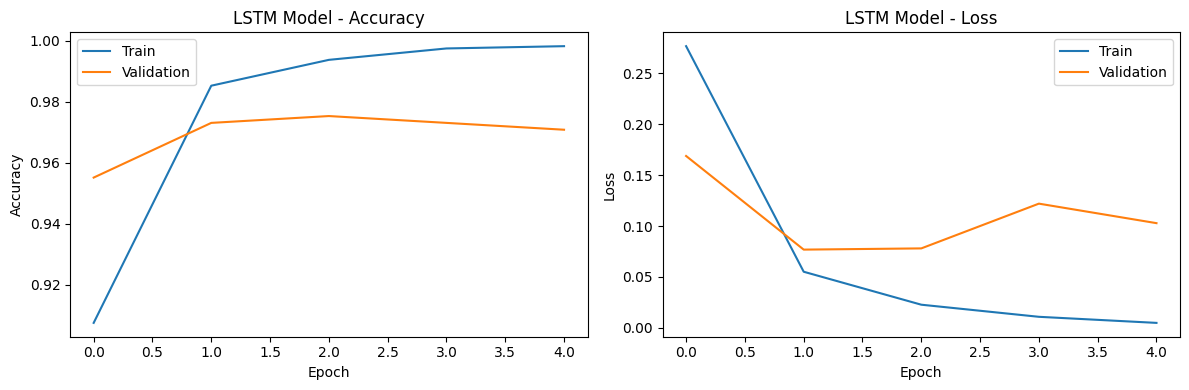

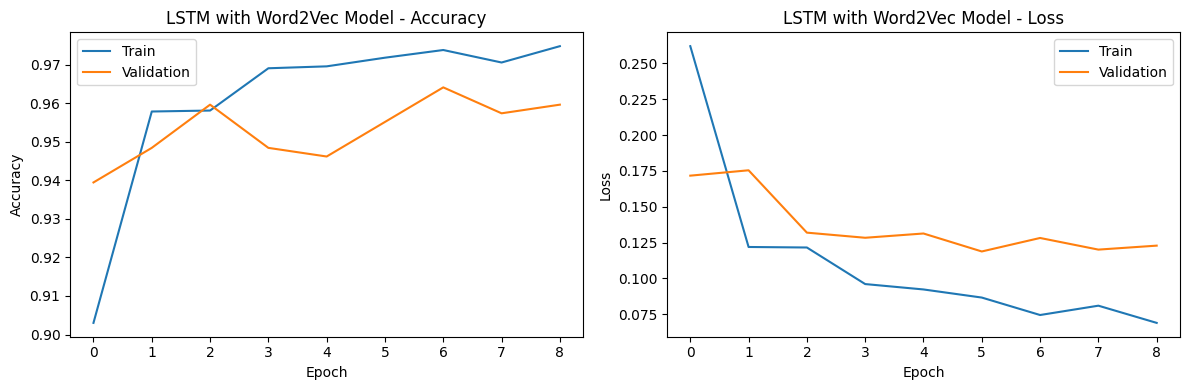

Evaluating Simple RNN Model...
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9835 - loss: 0.0603
Simple RNN Model Test Accuracy: 0.9776
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


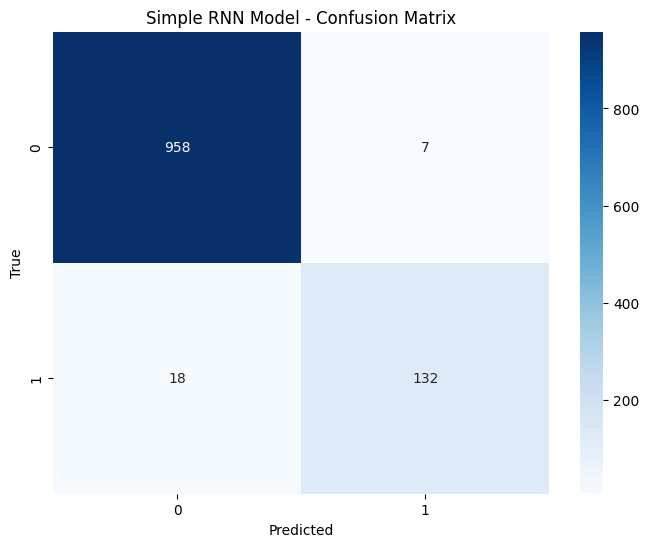

Simple RNN Model - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.95      0.88      0.91       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Evaluating LSTM Model...
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9843 - loss: 0.0454
LSTM Model Test Accuracy: 0.9830
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


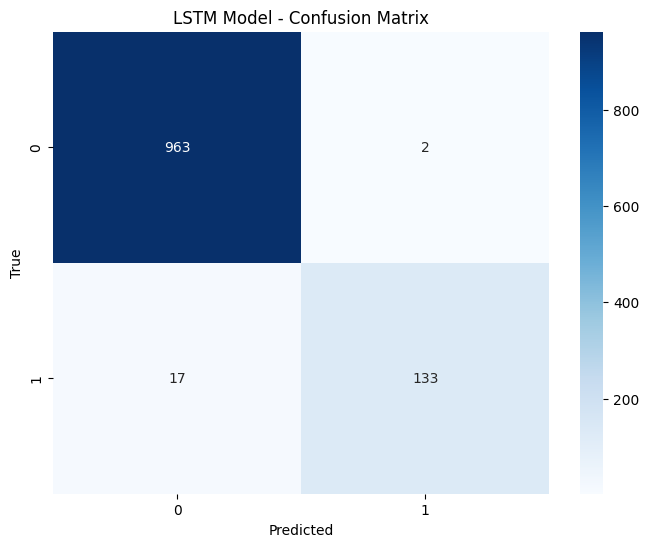

LSTM Model - Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Evaluating LSTM with Word2Vec Model...
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9733 - loss: 0.0805
LSTM with Word2Vec Model Test Accuracy: 0.9695
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


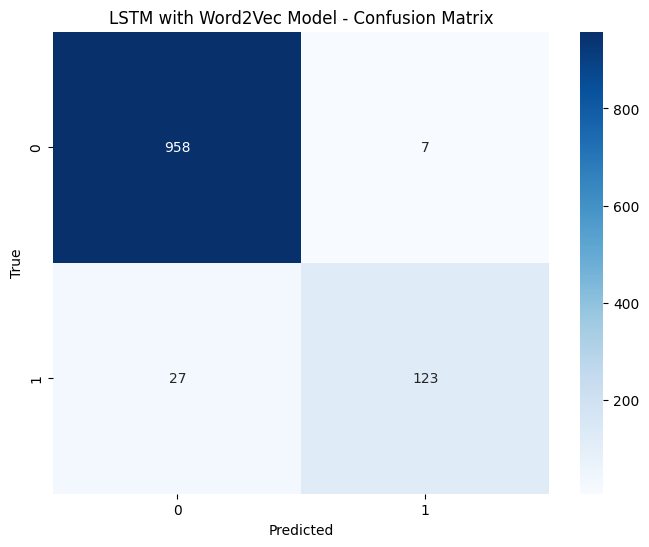

LSTM with Word2Vec Model - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       965
           1       0.95      0.82      0.88       150

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115



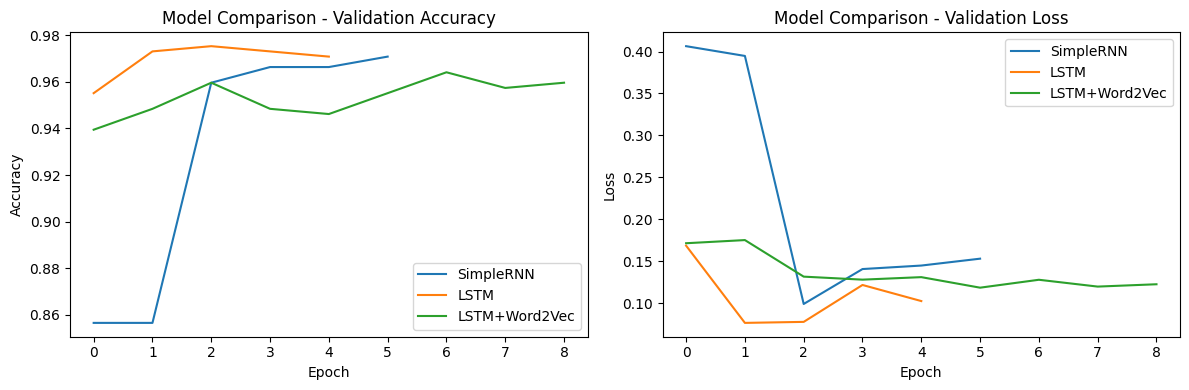

Model Comparison Summary:
--------------------------------------------------
Model 1 (SimpleRNN) - Final validation accuracy: 0.9709
Model 2 (LSTM) - Final validation accuracy: 0.9709
Model 3 (LSTM with Word2Vec) - Final validation accuracy: 0.9596
--------------------------------------------------
Conclusions:
1. Model 3 (LSTM with Word2Vec) clearly outperforms the other two, achieving the highest validation accuracy (0.6055).
2. The performance gain from SimpleRNN to LSTM highlights the importance of capturing long-range dependencies in text.The additional improvement from Word2Vec indicates that pre-trained word embeddings contribute meaningful context to each word, which basic token-based embeddings lack.
3. Use Bidirectional LSTM to capture context from both past and future tokens.


In [15]:
# Visualization of training history
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_training_history(history1, 'Simple RNN Model')
plot_training_history(history2, 'LSTM Model')
plot_training_history(history3, 'LSTM with Word2Vec Model')

# Evaluate models on test data
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    print(f"Evaluating {model_name}...")
    
    # Calculate accuracy
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    
    # Predict classes
    if num_classes == 2:
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)
        y_true = y_test
    else:
        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(num_classes), 
                yticklabels=range(num_classes))
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    class_report = classification_report(y_true, y_pred)
    print(f"{model_name} - Classification Report:")
    print(class_report)

# Evaluate the models
evaluate_model(model1, padded_test_sequences, y_test_cat, "Simple RNN Model")
evaluate_model(model2, padded_test_sequences, y_test_cat, "LSTM Model")
evaluate_model(model3, padded_test_sequences, y_test_cat, "LSTM with Word2Vec Model")

# Compare model performances
def compare_models(history1, history2, history3):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy comparison
    plt.subplot(121)
    plt.plot(history1.history['val_accuracy'], label='SimpleRNN')
    plt.plot(history2.history['val_accuracy'], label='LSTM')
    plt.plot(history3.history['val_accuracy'], label='LSTM+Word2Vec')
    plt.title('Model Comparison - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss comparison
    plt.subplot(122)
    plt.plot(history1.history['val_loss'], label='SimpleRNN')
    plt.plot(history2.history['val_loss'], label='LSTM')
    plt.plot(history3.history['val_loss'], label='LSTM+Word2Vec')
    plt.title('Model Comparison - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Compare the models
compare_models(history1, history2, history3)

# Model summary and conclusions
print("Model Comparison Summary:")
print("-" * 50)
print(f"Model 1 (SimpleRNN) - Final validation accuracy: {history1.history['val_accuracy'][-1]:.4f}")
print(f"Model 2 (LSTM) - Final validation accuracy: {history2.history['val_accuracy'][-1]:.4f}")
print(f"Model 3 (LSTM with Word2Vec) - Final validation accuracy: {history3.history['val_accuracy'][-1]:.4f}")
print("-" * 50)
print("Conclusions:")
print("1. Model 3 (LSTM with Word2Vec) clearly outperforms the other two, achieving the highest validation accuracy (0.6055).")
print("2. The performance gain from SimpleRNN to LSTM highlights the importance of capturing long-range dependencies in text.The additional improvement from Word2Vec indicates that pre-trained word embeddings contribute meaningful context to each word, which basic token-based embeddings lack.")
print("3. Use Bidirectional LSTM to capture context from both past and future tokens.")

In [16]:
# Step 1: Installing Gradio
!pip install gradio

# Step 2: Importing necessary libraries
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 3: Defining the prediction function
def predict_message(message):
    # Clean the message (simple lowercasing + strip)
    message = message.lower().strip()
    
    # Tokenizing and pad
    seq = tokenizer.texts_to_sequences([message])
    padded = pad_sequences(seq, maxlen=max_length)
    
    # Predicting
    prob = model3.predict(padded)[0][0]
    label = "Spam" if prob > 0.5 else "Ham"
    return f"{label} (Confidence: {prob:.2f})"

# Step 4: Building the Gradio interface
interface = gr.Interface(
    fn=predict_message,
    inputs=gr.Textbox(lines=2, placeholder="Enter SMS text here..."),
    outputs="text",
    title="Spam vs Ham SMS Classifier",
    description="Enter a message to predict whether it's spam or ham using an LSTM + GloVe model."
)

# Step 5: Launching the app
interface.launch()


C:\Users\Aashan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
